In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

In [2]:
data_movies = pd.read_csv('../ml-32m/movies.csv')
data_tags = pd.read_csv('../ml-32m/tags.csv')
data_ratings = pd.read_csv('../ml-32m/ratings.csv')


In [3]:
print(data_movies.shape)
print(data_tags.shape)
print(data_ratings.shape)

(87585, 3)
(2000072, 4)
(32000204, 4)


In [4]:
print(data_movies.dtypes)
print(data_tags.dtypes)
print(data_ratings.dtypes)

movieId     int64
title      object
genres     object
dtype: object
userId        int64
movieId       int64
tag          object
timestamp     int64
dtype: object
userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object


In [5]:
data_tags['tag'] = data_tags['tag'].fillna('').astype(str)

In [6]:
genres = data_movies['genres'].str.split('|').explode()

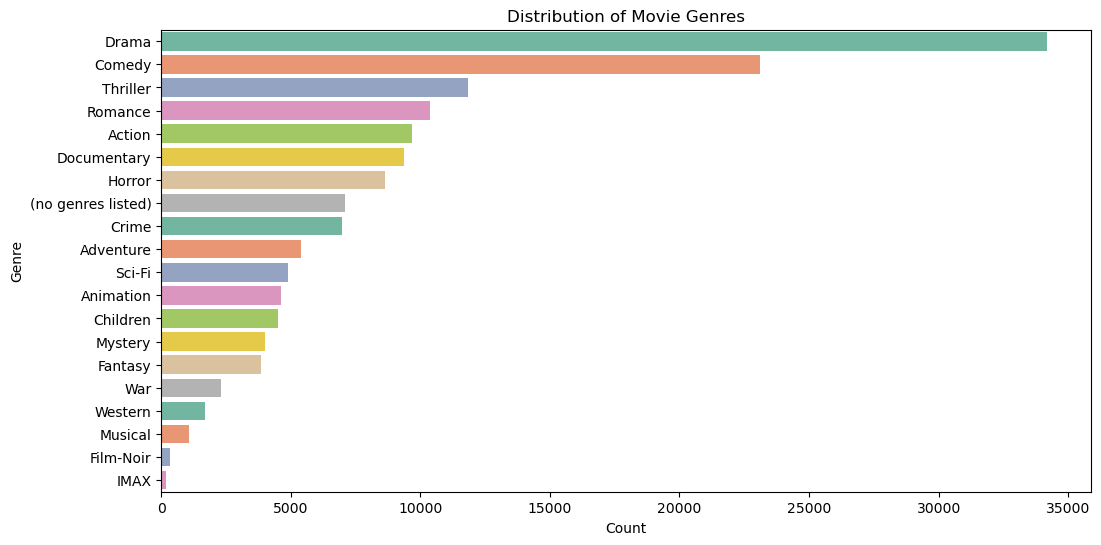

In [7]:
# Plotting the genre distribution
plt.figure(figsize=(12, 6))
sns.countplot(y=genres, order=genres.value_counts().index, palette='Set2')
plt.title("Distribution of Movie Genres")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.show()


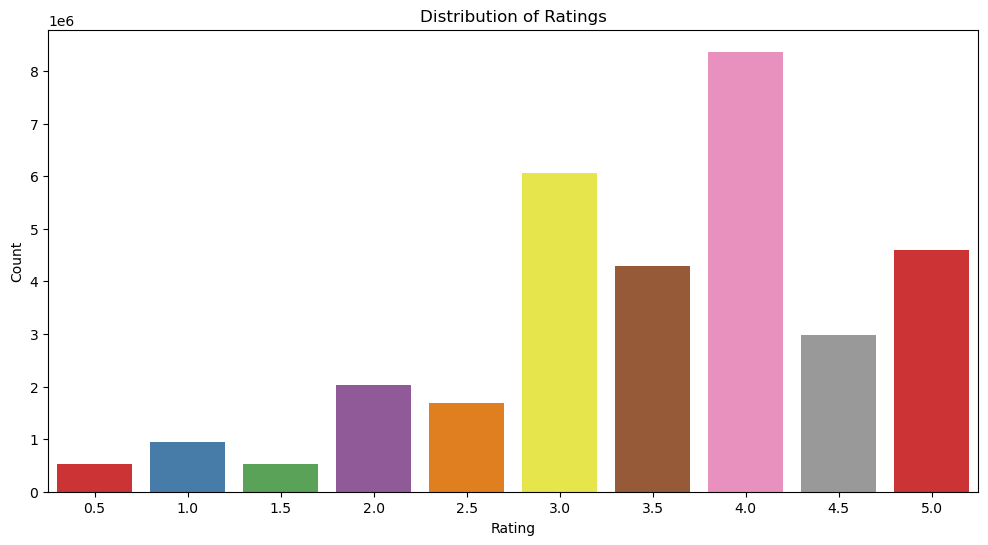

In [8]:
plt.figure(figsize=(12, 6))
sns.countplot(x='rating', data=data_ratings, palette='Set1', order=sorted(data_ratings['rating'].unique()))
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

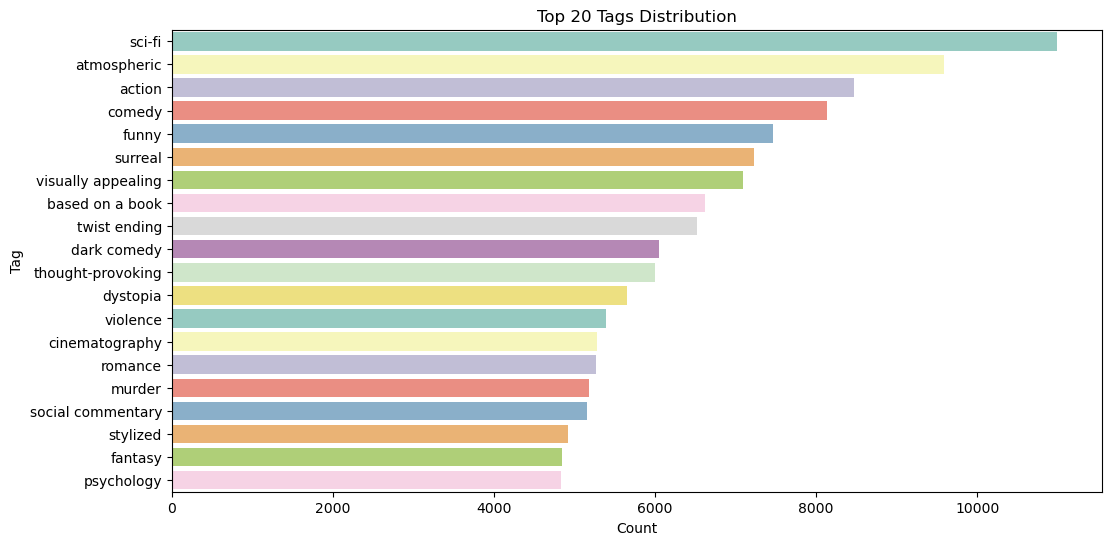

In [9]:
tags = data_tags['tag'].explode()

# Get the top 20 most frequent tags
top_20_tags = tags.value_counts().head(20)

# Plot the distribution of the top 20 tags
plt.figure(figsize=(12, 6))
sns.barplot(y=top_20_tags.index, x=top_20_tags.values, palette='Set3')
plt.title("Top 20 Tags Distribution")
plt.xlabel("Count")
plt.ylabel("Tag")
plt.show()

In [10]:
avg_ratings = data_ratings.groupby('movieId')['rating'].mean().reset_index()
avg_ratings.columns = ['movieId', 'avg_rating']

In [11]:
tags_combined = data_tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()

In [12]:
movies_with_features = pd.merge(data_movies, avg_ratings, on='movieId', how='left')
movies_with_features = pd.merge(movies_with_features, tags_combined, on='movieId', how='left')

In [13]:
movies_with_features['genres'] = movies_with_features['genres'].str.split('|')
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(movies_with_features['genres'])

In [14]:
tfidf = TfidfVectorizer(max_features=10000, stop_words='english')
tags_tfidf = tfidf.fit_transform(movies_with_features['tag'].fillna(''))

In [15]:
ratings_array = movies_with_features['avg_rating'].fillna(0).values.reshape(-1, 1)
combined_features = hstack([genres_encoded, ratings_array, tags_tfidf])
combined_features_dense = combined_features.toarray()

In [16]:
model = NearestNeighbors(n_neighbors=11, algorithm='auto', metric='cosine', n_jobs=-1)
model.fit(combined_features_dense)

def get_recommendations(movie_title, top_n=10):
    # Get the index of the movie
    idx = movies_with_features[movies_with_features['title'] == movie_title].index[0]
    
    # Find the most similar movies
    distances, indices = model.kneighbors(combined_features_dense[idx:idx+1], top_n+1)
    
    # Exclude the queried movie itself
    similar_indices = indices[0][1:]
    
    # Return the top_n movie titles
    return movies_with_features.iloc[similar_indices][['title', 'avg_rating']]


In [17]:
print(get_recommendations('Toy Story (1995)', top_n=10))

                                     title  avg_rating
3021                    Toy Story 2 (1999)    3.812043
4781                 Monsters, Inc. (2001)    3.837442
79484         Casper's Scare School (2006)    4.500000
72526     Legends of Valhalla: Thor (2011)    4.500000
80263              Pil's Adventures (2021)    3.375000
48471              The Dragon Spell (2016)    3.333333
79914       Christmas in Tattertown (1988)    3.250000
75375                          Luca (2021)    3.638158
69923                          Soul (2020)    3.911948
84031  Puss in Boots: The Last Wish (2022)    3.921983
